# Рекомендация тарифов

## Описание проекта

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

### Описание данных

Путь к файлу: *datasets/users_behavior.csv*

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
 - *сalls* — количество звонков,
 - *minutes* — суммарная длительность звонков в минутах,
 - *messages* — количество sms-сообщений,
 - *mb_used* — израсходованный интернет-трафик в Мб,
 - *is_ultra* — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Оглавление

1. [Открытие файла с данными и изучение общей информации](#step_1)
2. [Подготовка данных](#step_2)
3. [Исследование моделей](#step_3)
4. [Проверка модели на тестовых данных](#step_4)
5. [Проверка модели на адекватность](#step_5)

## 1. Откройте и изучите файл
<a id="step_1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [7]:
smart = df.query('is_ultra == 0')
ultra = df.query('is_ultra == 1')

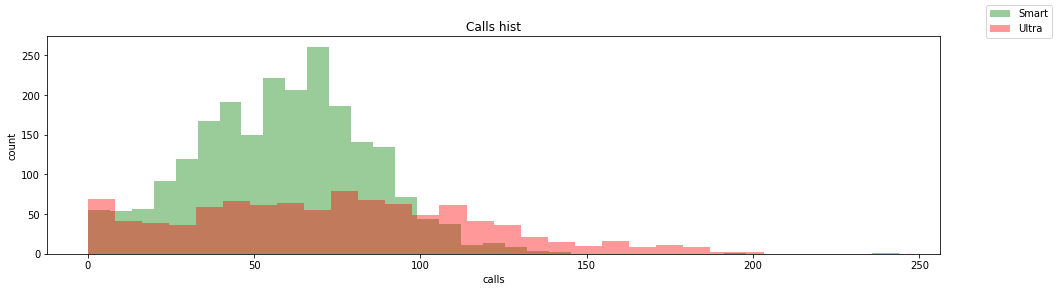

In [8]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(smart['calls'], kde=False, bins=30, color='g').set(title='Calls hist', xlabel='calls', ylabel='count')
sns.distplot(ultra['calls'], kde=False, bins=30, color='r').set(title='Calls hist', xlabel='calls', ylabel='count')
fig.legend(labels=['Smart','Ultra'])
plt.show()

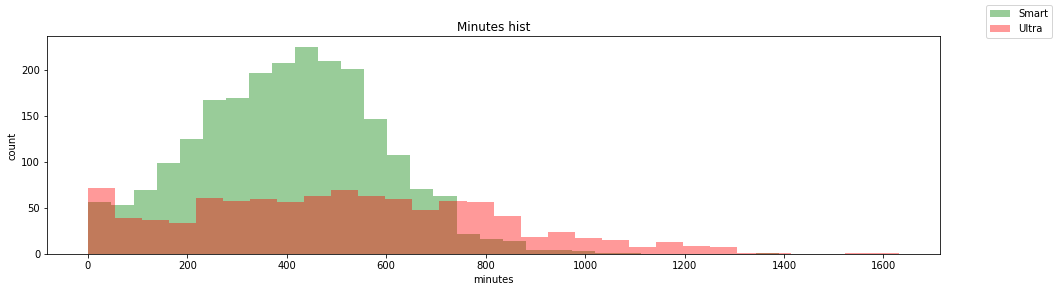

In [9]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(smart['minutes'], kde=False, bins=30, color='g').set(title='Minutes hist', xlabel='minutes', ylabel='count')
sns.distplot(ultra['minutes'], kde=False, bins=30, color='r').set(title='Minutes hist', xlabel='minutes', ylabel='count')
fig.legend(labels=['Smart','Ultra'])
plt.show()

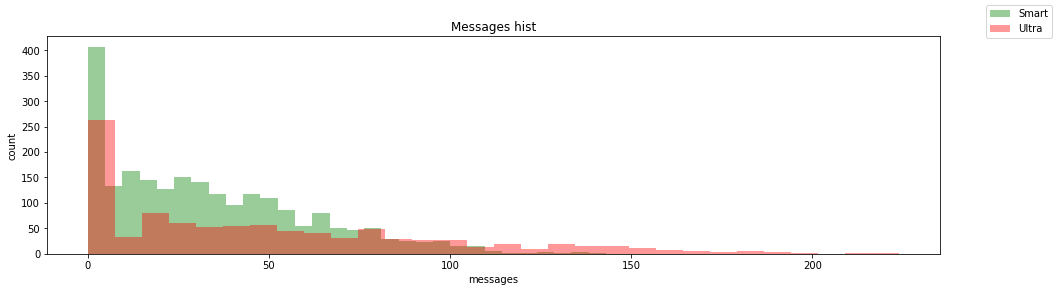

In [10]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(smart['messages'], kde=False, bins=30, color='g').set(title='Messages hist', xlabel='messages', ylabel='count')
sns.distplot(ultra['messages'], kde=False, bins=30, color='r').set(title='Messages hist', xlabel='messages', ylabel='count')
fig.legend(labels=['Smart','Ultra'])
plt.show()

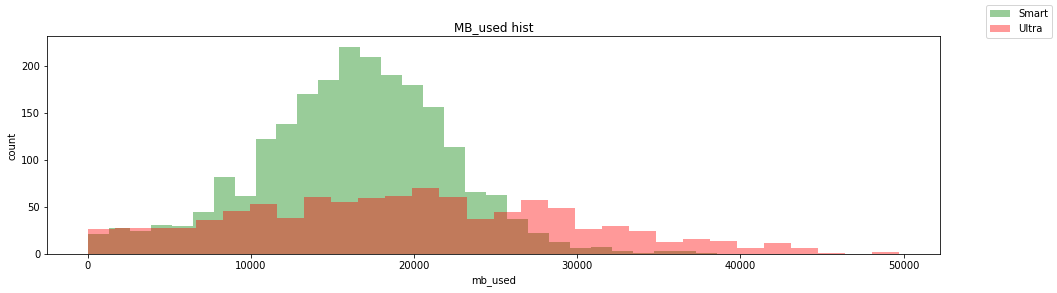

In [11]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(smart['mb_used'], kde=False, bins=30, color='g').set(title='MB_used hist', xlabel='mb_used', ylabel='count')
sns.distplot(ultra['mb_used'], kde=False, bins=30, color='r').set(title='MB_used hist', xlabel='mb_used', ylabel='count')
fig.legend(labels=['Smart','Ultra'])
plt.show()

У нас 3214 строк с данными по клиентам. Есть данные по кол-ву звонков, кол-во сообщений, длительности звонков, объему интернет-трафика и тариф. 

Около 69% данных относится к тарифу **Смарт**.

## 2. Разбейте данные на выборки
<a id="step_2"></a>

In [12]:
seed = 12345

In [13]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [14]:
features_train, features_tt, target_train, target_tt = train_test_split(
    features, 
    target, 
    test_size=0.4, 
    random_state=seed
)

In [15]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_tt, 
    target_tt, 
    test_size=0.5, 
    random_state=seed
)

In [16]:
(features_train.shape, features_valid.shape, features_test.shape, target_train.shape, target_valid.shape, target_test.shape)

((1928, 4), (643, 4), (643, 4), (1928,), (643,), (643,))

In [17]:
features_train.shape[0] + features_valid.shape[0] + features_test.shape[0] == features.shape[0]

True

Разбили датасет на 3 выборки в соотношении 3:1:1, обучающая выборка 60% от исходных данных, валидационная 20% и тестовая 20%:

- *features_train*, *target_train* - обучающая выборка
- *features_valid*, *target_valid* - валидационная выборка
- *features_test*, *target_test* - тестовая выборка

## 3. Исследуйте модели
<a id="step_3"></a>

### Дерево решений

In [18]:
DT_model = None
best_result = 0
best_depth = 0

for depth in range(1,30):
    model = DecisionTreeClassifier(random_state=seed, max_depth=depth)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        DT_model = model
        best_result = result
        best_depth = depth
        
print(f'DecisionTreeClassifier: accuracy: {best_result}, depth={best_depth}')

DecisionTreeClassifier: accuracy: 0.7853810264385692, depth=3


Дерево решений показало долю правильных ответов accuracy 0.78 с глубиной дерева равной 3. 

Не плохой результат, но скорее всего не будет самым лучшим.

### Случайный лес

In [19]:
RF_model = None
best_result = 0
best_depth = 0
best_est = 0

for est in range(1,11):
    for depth in range(1,10):
        model = RandomForestClassifier(random_state=seed, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        if result > best_result:
            RF_model = model
            best_result = result
            best_depth = depth
            best_est = est
        
print(f'RandomForestClassifier accuracy: {best_result}, depth={best_depth}, estimators={est}')

RandomForestClassifier accuracy: 0.80248833592535, depth=8, estimators=10


Случайный лес, показал результат немного лучше accuracy 0.80. 

Мы остановились на кол-ве деревьев 10, 
т.к. дальше модель начинает слишком долго обучаться, а результат изменяется незначительно.

### Логистическая регрессия

In [20]:
LR_model = LogisticRegression(random_state=seed)
LR_model.fit(features_train, target_train)
result = LR_model.score(features_valid, target_valid)

print(f'LogisticRegression accuracy: {result}')

LogisticRegression accuracy: 0.7589424572317263


Логистическая регрессия показала худший результат accuracy: 0.75, но модель значительно быстрее обучается.

## 4. Проверьте модель на тестовой выборке
<a id="step_4"></a>

In [21]:
result = DT_model.score(features_test, target_test)
print(f'DecisionTreeClassifier: accuracy: {result}')

DecisionTreeClassifier: accuracy: 0.7791601866251944


In [22]:
result = RF_model.score(features_test, target_test)
print(f'RandomForestClassifier accuracy: {result}')

RandomForestClassifier accuracy: 0.7962674961119751


In [23]:
result = LR_model.score(features_test, target_test)
print(f'LogisticRegression accuracy: {result}')

LogisticRegression accuracy: 0.7402799377916018


Проверили все 3 модели на тестовых данных, результат остались такими же. Лучшая можель - случайный лес, выдающая долю правильных ответов на тестовой выборке 0.79.

## 5. (Бонус) Проверьте модели на адекватность
<a id="step_5"></a>

In [24]:
smart.shape[0] / df.shape[0]

0.693528313627878

Еще в самом начале мы отметили что около 69% значений относится к тарифу **Смарт**, если предположить с такой же пропорцией тарифы и дальше будут распределяться, то получается что наша модель будет более точной, т.к. доля вернызх ответов у нас больше 0.79 против 0.69.